<a href="https://colab.research.google.com/github/Kolibri5/Movie-Sentiment-Analysis/blob/main/Movie_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Sentiment Analysis

**Objective:**  
To build an automated ETL (Extract, Transform, Load) pipeline that analyzes public sentiment for movies using the TMDB API. This project explores how audience perceptions shift over time and across different genres using Natural Language Processing (NLP).

**Methodology:**
- **Data Engineering:** Automated extraction of movie metadata and reviews using requests with robust error handling.

- **NLP Engine:** Sentiment analysis via TextBlob and part-of-speech (POS) filtering using NLTK to isolate descriptive language.

- **Advanced Analytics:** Aspect-Based Sentiment Analysis (ABSA) for specific movie elements and Temporal Analysis to track genre trends.

### Setup and Configuration

#### Imports

In [1]:
import pandas as pd
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings

#### Resource Configuration

In [2]:
warnings.filterwarnings('ignore')
nltk.download(['punkt', 'averaged_perceptron_tagger', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger_eng'], quiet=True)
lemmatizer = WordNetLemmatizer()

#### API Settings


##### Getting a TMDB API Key

1.  Go to [The Movie Database (TMDB) website](https://www.themoviedb.org/).
2.  Sign up for a free account if you don't already have one.
3.  Once logged in, navigate to your profile settings.
4.  On the left sidebar, click on 'API'.
5.  Request a new API key (Developer).
6.  Agree to the terms of use.
7.  You will then be granted a v3 API Key. Copy this key.
8.  In Google Colab, click on the '🔑' icon (Secrets) in the left panel.
9.  Add a new secret and name it `TMDB_API_KEY`. Paste your copied TMDB API key as the value.
10. Ensure 'Notebook access' is enabled for this secret.

**Important:** To securely store your API key, add it to Colab's Secrets manager under the "🔑" icon in the left panel. Name the secret `TMDB_API_KEY`.

In [3]:
from google.colab import userdata

API_KEY = userdata.get('TMDB_API_KEY')
BASE_URL = 'https://api.themoviedb.org/3'
MAX_PAGES = 20
LANGUAGE = 'en-US'

#### Helper: Mapping Genre IDs to Names

In [4]:
def get_genre_map():
    url = f"{BASE_URL}/genre/movie/list?api_key={API_KEY}&language={LANGUAGE}"
    resp = requests.get(url)
    if resp.status_code == 200:
        genres = resp.json().get('genres', [])
        return {g['id']: g['name'] for g in genres}
    return {}

GENRE_MAP = get_genre_map()

### Data Extraction Pipeline
This pipeline retrieves the most popular movies and iterates through their individual reviews.

In [5]:
def fetch_comprehensive_data(max_pages=5):
    all_data = []
    print(f"Starting extraction for {max_pages} pages...")

    for page in range(1, max_pages + 1):
      try:
          discover_url = f"{BASE_URL}/discover/movie?api_key={API_KEY}&language={LANGUAGE}&sort_by=popularity.desc&page={page}"
          resp = requests.get(discover_url)
          resp.raise_for_status()

          movies = resp.json().get('results', [])
          for movie in movies:
              mid = movie['id']
              title = movie.get('title')
              genre_ids = movie.get('genre_ids', [])
              main_genre = GENRE_MAP.get(genre_ids[0], "Unknown") if genre_ids else "Unknown"
              popularity = movie.get('popularity')

              try:
                  rev_url = f"{BASE_URL}/movie/{mid}/reviews?api_key={API_KEY}&language={LANGUAGE}&page=1"
                  rev_resp = requests.get(rev_url, timeout=10)
                  if rev_resp.status_code == 200:
                      reviews = rev_resp.json().get('results', [])
                      for r in reviews:
                          all_data.append({
                              'movie_id': mid,
                              'title': title,
                              'genre': main_genre,
                              'popularity': popularity,
                              'author': r.get('author', 'anonymous'),
                              'rating': r.get('author_details', {}).get('rating'),
                              'content': r.get('content', ''),
                              'created_at': r.get('created_at')
                          })
              except requests.exceptions.RequestException as e:
                    print(f"Warning: Could not fetch reviews for {title}: {e}")

              time.sleep(0.2)
          print(f"Page {page} completed.")
      except Exception as e:
          print(f"Critical Error on page {page}: {e}")
          break

    return pd.DataFrame(all_data)

In [6]:
raw_df = fetch_comprehensive_data(MAX_PAGES)

Starting extraction for 20 pages...
Page 1 completed.
Page 2 completed.
Page 3 completed.
Page 4 completed.
Page 5 completed.
Page 6 completed.
Page 7 completed.
Page 8 completed.
Page 9 completed.
Page 10 completed.
Page 11 completed.
Page 12 completed.
Page 13 completed.
Page 14 completed.
Page 15 completed.
Page 16 completed.
Page 17 completed.
Page 18 completed.
Page 19 completed.
Page 20 completed.


### Data Transformation and NLP Sentiment Analysis
In this cell, we perform data cleaning and use Part-of-Speech (POS) tagging to isolate adjectives and adverbs for the sentiment-specific WordCloud.

#### Extract Sentiment Words

In [7]:
def extract_sentiment_words(text):
    # List to exclude colors and generic movie noise
    custom_stopwords = {
        'really', 'visually', 'actually', 'even', 'still', 'much', 'well',
        'also', 'back', 'first', 'little', 'many', 'quite', 'look', 'see',
        'black', 'white', 'red', 'blue', 'green', 'yellow', 'dark', 'light',
        'another', 'every', 'part', 'way', 'thing', 'ever', 'make', 'made'
    }

    words = word_tokenize(text.lower())
    tagged_words = nltk.pos_tag(words)

    pos_words = []
    neg_words = []

    for word, tag in tagged_words:
        # Lemmatize the word to its root form
        lemma = lemmatizer.lemmatize(word, pos='a') # 'a' for adjective

        if (tag.startswith('JJ') or tag.startswith('RB')) and len(lemma) > 2:
            if lemma not in custom_stopwords:
                word_polarity = TextBlob(lemma).sentiment.polarity
                if word_polarity > 0.1:
                    pos_words.append(lemma)
                elif word_polarity < -0.1:
                    neg_words.append(lemma)

    return " ".join(pos_words), " ".join(neg_words)

#### Transform and Analyze

In [8]:
def transform_and_analyze(df):
    # Cleaning
    df = df.dropna(subset=['content']).drop_duplicates(subset=['movie_id', 'author', 'content']).copy()
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # LP Overall Sentiment Analysis (for the Box Plot/Charts)
    df['nlp_polarity'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment_label'] = df['nlp_polarity'].apply(
        lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral')
    )

    # New Word-Level Filtering (for the Word Clouds)
    sentiment_tuples = df['content'].apply(extract_sentiment_words)
    df['pos_adj'] = [t[0] for t in sentiment_tuples]
    df['neg_adj'] = [t[1] for t in sentiment_tuples]

    return df

#### Execution

In [9]:
clean_df = transform_and_analyze(raw_df)
clean_df.head()

,movie_id,title,genre,popularity,author,rating,content,created_at,nlp_polarity,sentiment_label,pos_adj,neg_adj
0,83533,Avatar: Fire and Ash,Science Fiction,490.3056,Manuel São Bento,5.0,FULL SPOILER-FREE REVIEW @ https://movieswetex...,2025-12-18T10:34:56.770Z,0.083961,Neutral,full creative memorable own own certain bright...,past cynical frustrating
1,83533,Avatar: Fire and Ash,Science Fiction,490.3056,Khushdave,NaN,One of the first things that stood out to me w...,2025-12-19T16:08:19.732Z,0.091675,Neutral,best more absolutely most impressive original ...,absurdly previous painful cruel chilling slowl...
2,83533,Avatar: Fire and Ash,Science Fiction,490.3056,Dean,5.0,"I give it 5/10 because, this 5 stars are for t...",2025-12-20T11:47:06.165Z,-0.144737,Negative,amazing beautiful sure perfect great,bad past bad guilty bad
3,83533,Avatar: Fire and Ash,Science Fiction,490.3056,Dave,NaN,The first film is a classic and really made 3...,2025-12-23T11:46:44.853Z,0.208730,Positive,classic original good strong fantastic notably...,
4,83533,Avatar: Fire and Ash,Science Fiction,490.3056,goinmental-33,8.0,I thought overall is really good movie which I...,2025-12-25T10:06:41.227Z,0.235278,Positive,good exceptional more great,long-winded


In [10]:
results = clean_df['content'].apply(extract_sentiment_words)
clean_df['pos_adj'] = [r[0] for r in results]
clean_df['neg_adj'] = [r[1] for r in results]

### NLP Analysis

#### Topic Modeling (LDA)
This identifies common themes across all reviews (e.g., plot, visuals, or acting).

##### Prepare Data

In [11]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(clean_df['content'])

##### Build LDA Model
identifying 6 main topics

In [12]:
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=6, random_state=42)

##### Display Top Words per Topic

In [13]:
for index, topic in enumerate(lda.components_):
    print(f"TOPIC #{index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("-" * 10)

TOPIC #1:
['great', 'action', 'really', 'time', 'good', 'just', 'story', 'like', 'film', 'movie']
----------
TOPIC #2:
['django', 'years', 'world', 'harry', 'story', 'time', 'just', 'really', 'like', 'film']
----------
TOPIC #3:
['sinners', 'good', 'new', 'time', 've', 'music', 'like', 'just', 'film', 'em']
----------
TOPIC #4:
['work', 'new', 'just', 'action', 'frankenstein', 'christmas', 'predator', 'like', 'superman', 'film']
----------
TOPIC #5:
['family', 'does', 'film', 'little', 'good', 'really', 'bit', 'story', 'quite', 'just']
----------
TOPIC #6:
['performances', 'time', 'character', 'movie', 'narrative', 'like', 'world', 'review', 'story', 'film']
----------


##### **Interpretation of LDA Topics**

Based on the top words for each topic, we can infer the following themes from the movie reviews:

* **TOPIC #1: General Movie Discourse & Quality**: This topic appears to capture broad discussions about a film's overall quality, characters, and the cinematic experience, with words like 'best', 'work', 'film', and 'movie' being prominent.

* **TOPIC #2: Holiday/Themed Films & General Positive Sentiment**: The keyword 'christmas' strongly suggests that this topic might relate to holiday-themed movies or films released during specific seasons. It also includes general positive terms like 'great' and 'good', focusing on the 'story'.

* **TOPIC #3: Character & Story-Driven Appreciation**: Similar to Topic 1, but with a more pronounced focus on 'characters' and 'story' elements, alongside strong positive indicators ('great', 'good', 'really'), suggesting reviews that delve into the narrative and personalities.

* **TOPIC #4: Franchise, Action, and Narrative Reviews**: This topic highlights discussions around 'franchise' films, 'new' installments, 'action' sequences, and the overall 'narrative' structure, often in a comparative or review context.

* **TOPIC #5: Character Development & Action Focus (with a male perspective)**: This topic seems to center on 'character' arcs, 'action' sequences, and the 'story', with the word 'man' potentially indicating discussions around male protagonists or specific character archetypes.

* **TOPIC #6: Specific Action/Story-Driven Content (potentially 'John Wick' related)**: The specific name 'john' appearing with 'action', 'story', and 'good' strongly suggests this topic is capturing discussions about a particular movie series or character, most notably 'John Wick', which is known for its action and story.

#### Aspect-Based Sentiment Analysis (ABSA)
Analyzes sentiment toward specific "aspects" like the story or characters.

In [14]:
def get_aspect_sentiment(text, aspect_keywords):
    sentences = text.split('.')
    aspect_scores = []
    for sentence in sentences:
        if any(keyword in sentence.lower() for keyword in aspect_keywords):
            aspect_scores.append(TextBlob(sentence).sentiment.polarity)
    return np.mean(aspect_scores) if aspect_scores else None

##### Example: Check sentiment for 'Acting' vs 'Plot'

In [15]:
clean_df['acting_sentiment'] = clean_df['content'].apply(lambda x: get_aspect_sentiment(x, ['acting', 'performance', 'actor']))
clean_df['plot_sentiment'] = clean_df['content'].apply(lambda x: get_aspect_sentiment(x, ['plot', 'story', 'script']))

print(f"Average Acting Sentiment: {clean_df['acting_sentiment'].mean():.2f}")
print(f"Average Plot Sentiment: {clean_df['plot_sentiment'].mean():.2f}")

Average Acting Sentiment: 0.24
Average Plot Sentiment: 0.16


##### **Interpretation of Aspect-Based Sentiment Analysis (ABSA) for 'Acting' vs 'Plot'**

The results show that:
- **Average Acting Sentiment: 0.24**
- **Average Plot Sentiment: 0.16**

This indicates that, on average, movie reviews express a more positive sentiment towards the 'acting' and 'performance' aspects of movies compared to the 'plot' and 'story'. Both aspects generally receive positive feedback, but the performances appear to be slightly better received than the narrative elements.

This type of analysis is incredibly useful for understanding specific strengths and weaknesses of films as perceived by the audience, rather than just an overall sentiment.

##### **Suggestions for Other ABSA Keywords**

To expand on Aspect-Based Sentiment Analysis, you could explore other aspects identified in the LDA topics. Here are some keyword suggestions for additional aspects:

* **Visuals/Cinematography**: `['visuals', 'cinematography', 'effects', 'CGI', 'photography', 'look', 'scenery']`

* **Sound/Music**: `['sound', 'music', 'soundtrack', 'score', 'audio', 'design']`

* **Direction**: `['direction', 'director', 'filmmaking', 'vision']`

* **Pacing/Editing**: `['pacing', 'editing', 'flow', 'speed']`

* **Characters (General)**: `['characters', 'character development', 'personalities', 'portrayals']`

* **Dialogue**: `['dialogue', 'lines', 'script', 'writing']`

* **Action Sequences**: `['action', 'sequences', 'fights', 'stunts', 'choreography']`

* **Originality/Innovation**: `['originality', 'innovative', 'unique', 'fresh']`

### Exploratory Data Analysis and Visualization
Visualizing the results helps identify trends, such as which genres receive the most positive feedback and whether user ratings align with the sentiment of their text.

#### Set visual style

In [16]:
sns.set(style="whitegrid")

#### Sentiment Distribution by Genre

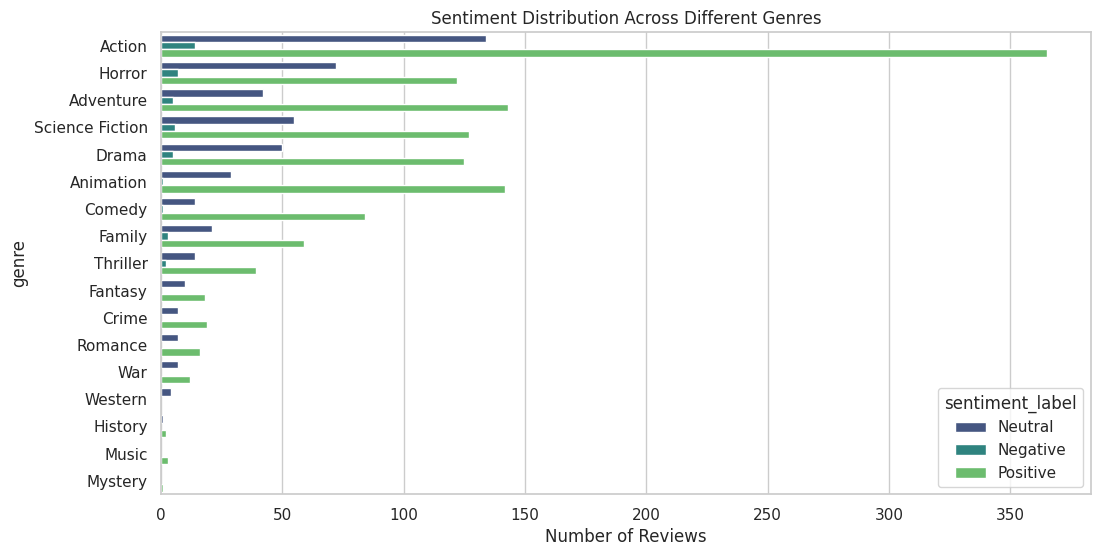

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, y='genre', hue='sentiment_label',
              palette='viridis', order=clean_df['genre'].value_counts().index)
plt.title('Sentiment Distribution Across Different Genres')
plt.xlabel('Number of Reviews')
plt.show()

The 'Sentiment Distribution Across Different Genres' plot is a countplot that visualizes the distribution of sentiment labels (Positive, Negative, Neutral) for movie reviews across various genres. Each bar represents a genre, and it's segmented by the sentiment label, showing the count of reviews for each sentiment category within that genre.

**Key Observations and Insights:**

* **Dominant Genres**: The plot immediately highlights which genres have the most reviews overall. Genres with longer combined bars (e.g., Action, Science Fiction, Adventure) indicate a higher volume of review data.

* **Overall Positive Bias**: For most genres, the 'Positive' sentiment bars are generally taller than 'Neutral' and 'Negative' bars. This suggests a general tendency for reviewers to express positive sentiment more frequently than negative or neutral sentiment, which is common in online reviews.

* **Genre-Specific Sentiment Trends**: You can observe if certain genres have a disproportionately high or low number of positive, neutral, or negative reviews. For example:

    * **Action** and **Adventure** often show a significant number of positive reviews, indicating these genres are generally well-received.

    * A genre might have a relatively higher proportion of 'Neutral' reviews if the films often elicit a less emotional response, or if the content is more informational.

    * If a genre has a noticeable 'Negative' bar, it could indicate areas where films in that genre are frequently falling short according to reviewers.

* **Comparison Across Genres**: The plot allows for quick visual comparisons. For instance, you can compare the ratio of positive to negative reviews in 'Action' vs. 'Horror' to see if one genre generally fares better in sentiment.

**How to Use This Information:**

* **Content Strategy**: For content creators or studios, this can inform decisions about which genres tend to resonate more positively with audiences.

* **Audience Understanding**: It helps in understanding audience expectations and general sentiment patterns associated with different film types.

* **Anomaly Detection**: Genres with an unexpectedly high proportion of negative reviews, despite a large review volume, might warrant further investigation.

#### Correlation between Numerical Rating and NLP Polarity

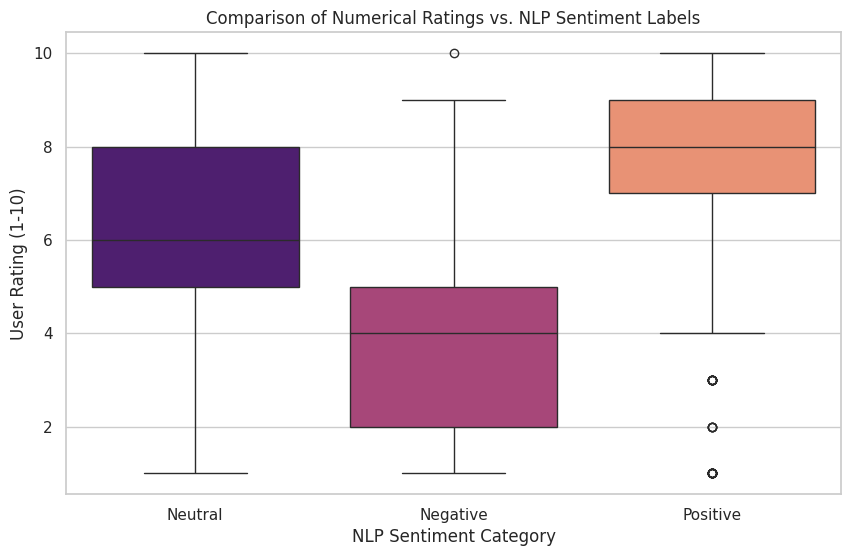

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=clean_df.dropna(subset=['rating']),
            x='sentiment_label', y='rating', palette='magma')
plt.title('Comparison of Numerical Ratings vs. NLP Sentiment Labels')
plt.xlabel('NLP Sentiment Category')
plt.ylabel('User Rating (1-10)')
plt.show()

This boxplot compares numerical ratings with NLP sentiment labels. Generally, **positive NLP reviews align with higher numerical ratings**, **negative NLP reviews align with lower numerical ratings**, and **neutral NLP reviews fall in the mid-range of numerical ratings**. This indicates a good correlation between the textual sentiment and the explicit numerical scores given by users. Any discrepancies could highlight interesting cases or limitations in sentiment detection.

**How to Use This Information:**

* **Validation of NLP Model:** This plot serves as a good validation check for the NLP sentiment analysis. A strong correlation (clear separation between the boxes) confirms that the NLP model is effectively capturing the underlying sentiment reflected in numerical ratings.

* **Understanding User Behavior:** It provides insight into how users express their opinions through different modalities (text vs. numerical scale).

* **Identifying Edge Cases:** Discrepancies can highlight interesting cases for further investigation, such as reviews that are positive in tone but still assign a low rating, or neutral reviews with unexpectedly high/low ratings. This could reveal subtle aspects of movie reception not immediately obvious.

#### Positive vs Negative Sentiment WordClouds

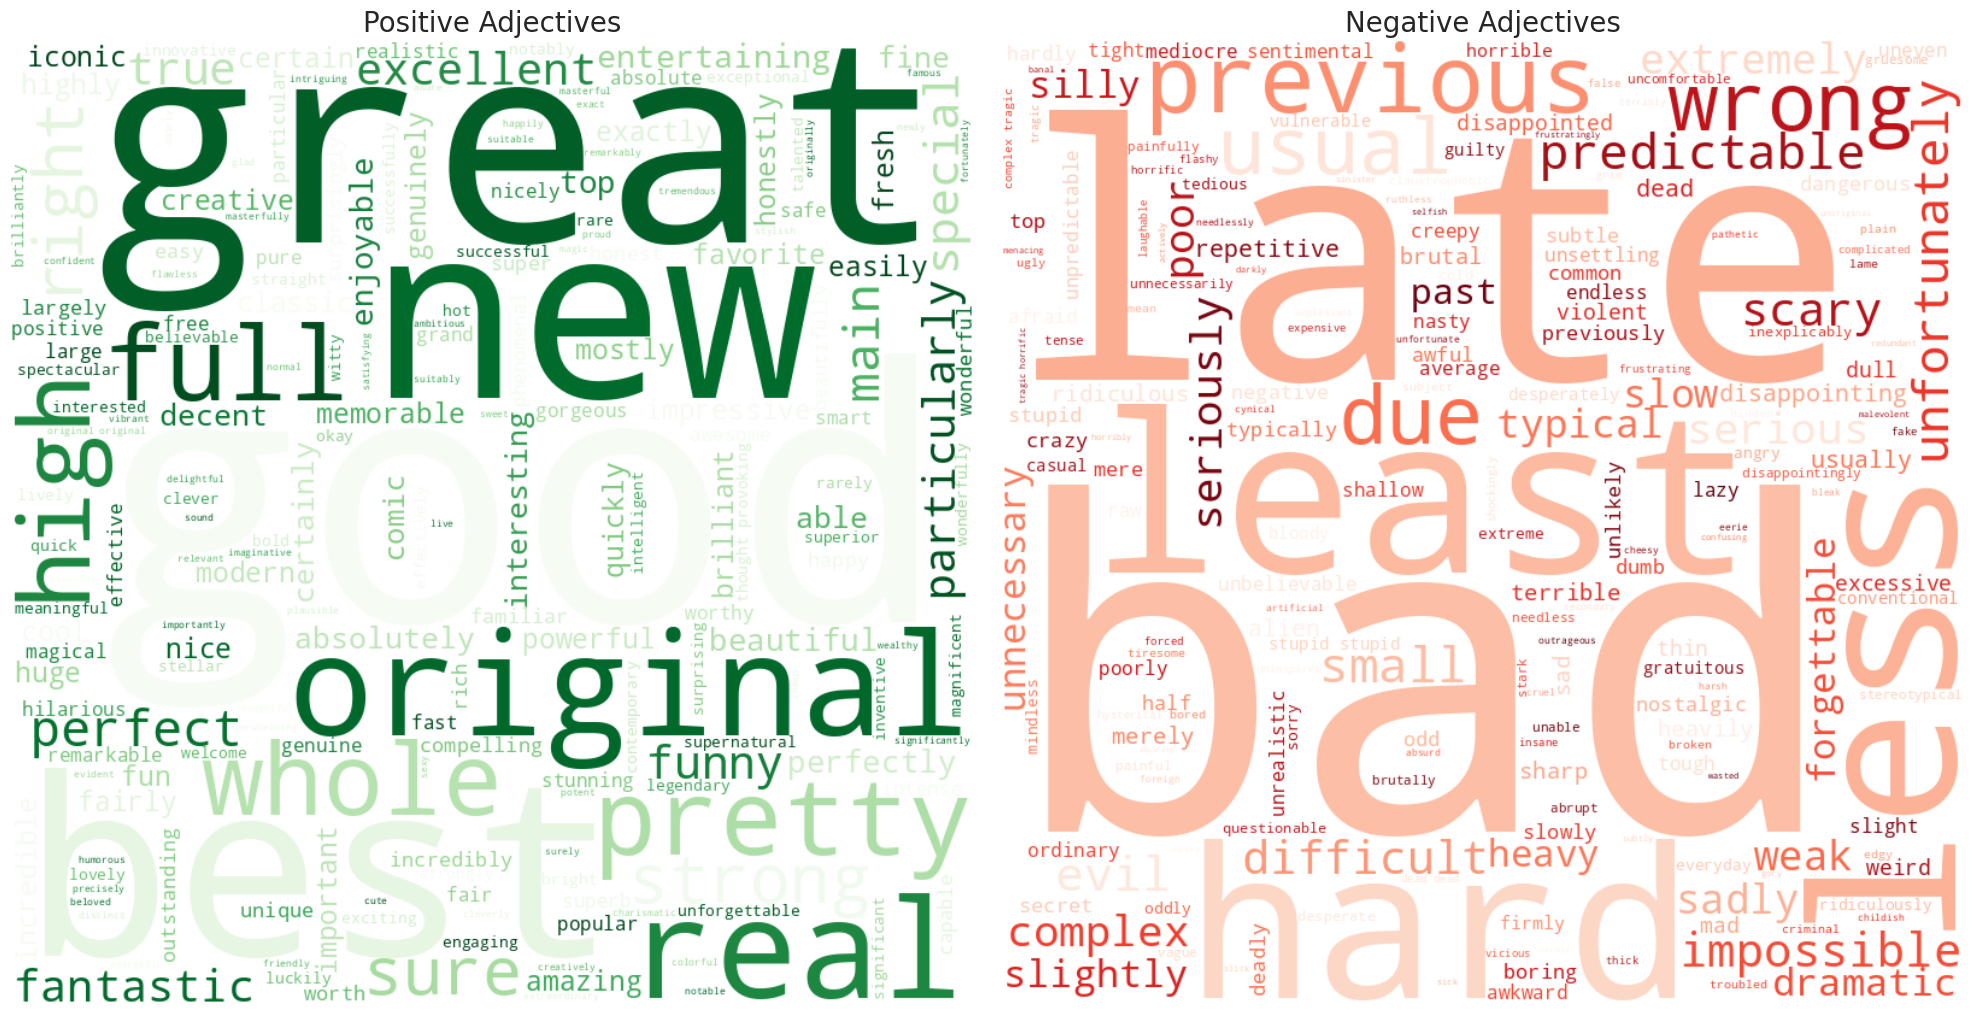

In [19]:
# Aggregate all positive and strictly negative adjectives
all_pos_adjectives = " ".join(clean_df['pos_adj'].tolist())
all_neg_adjectives = " ".join(clean_df['neg_adj'].tolist())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Positive Cloud
if all_pos_adjectives.strip():
    pos_cloud = WordCloud(width=800, height=800,
                          background_color='white',
                          colormap='Greens').generate(all_pos_adjectives)
    ax1.imshow(pos_cloud, interpolation='bilinear')
    ax1.set_title('Positive Adjectives', fontsize=20)
    ax1.axis('off')

# Negative Cloud
if all_neg_adjectives.strip():
    neg_cloud = WordCloud(width=800, height=800,
                          background_color='white',
                          colormap='Reds').generate(all_neg_adjectives)
    ax2.imshow(neg_cloud, interpolation='bilinear')
    ax2.set_title('Negative Adjectives', fontsize=20)
    ax2.axis('off')

plt.tight_layout()
plt.show()

These WordClouds visualize the most frequently used adjectives and adverbs in movie reviews, with word size proportional to their frequency. The Strictly Positive WordCloud (green) highlights terms like 'great' and 'amazing', while the Strictly Negative WordCloud (red) captures terms such as 'bad' and 'boring'.

**Key Observations and Insights:**

* **Dominant Descriptive Terms:** Quickly reveals the primary vocabulary used by audiences to express opinions.

* **Aspect Relevance:** Implies which movie elements drive sentiment, such as 'slow' for pacing or 'beautiful' for visuals.

* **Qualitative Summary:** Provides an immediate visual scan of audience feedback that numerical ratings alone cannot capture.

**Technical Considerations and Fine-Tuning:**

* **Noise and Context:** You may notice neutral words (e.g., 'really', 'actually') or objective descriptors (e.g., 'red', 'black', 'due') appearing in the clouds.

* **Lexical Challenges:** Automated POS tagging and polarity checks can occasionally misclassify words depending on the sentence structure or sarcasm.

* **Iterative Refinement:** These observations highlight the need for ongoing fine-tuning, such as expanding the custom stopword list or utilizing more advanced lemmatization to ensure the clouds remain strictly sentiment-focused.

**How to Use This Information:**

* Content Improvement: Helps filmmakers pinpoint specific audience appreciations or critiques.

* Marketing Strategy: Guides promotional efforts by identifying the most resonant positive language and addressing common negative themes.

#### Temporal Sentiment Analysis
This tracks how audience sentiment changes over time.

In [20]:
clean_df['created_at'] = pd.to_datetime(clean_df['created_at'])

# Resample and pivot
genre_trends = clean_df.groupby([pd.Grouper(key='created_at', freq='M'), 'genre'])['nlp_polarity'].mean().unstack()
# Smoothing and Filling Gaps
smoothed_trends = genre_trends.interpolate(method='linear', limit_direction='both').rolling(window=3, min_periods=1).mean()

# Only show top 5 genres to avoid "spaghetti" lines
top_genres = clean_df['genre'].value_counts().nlargest(5).index
filtered_trends = smoothed_trends[top_genres]

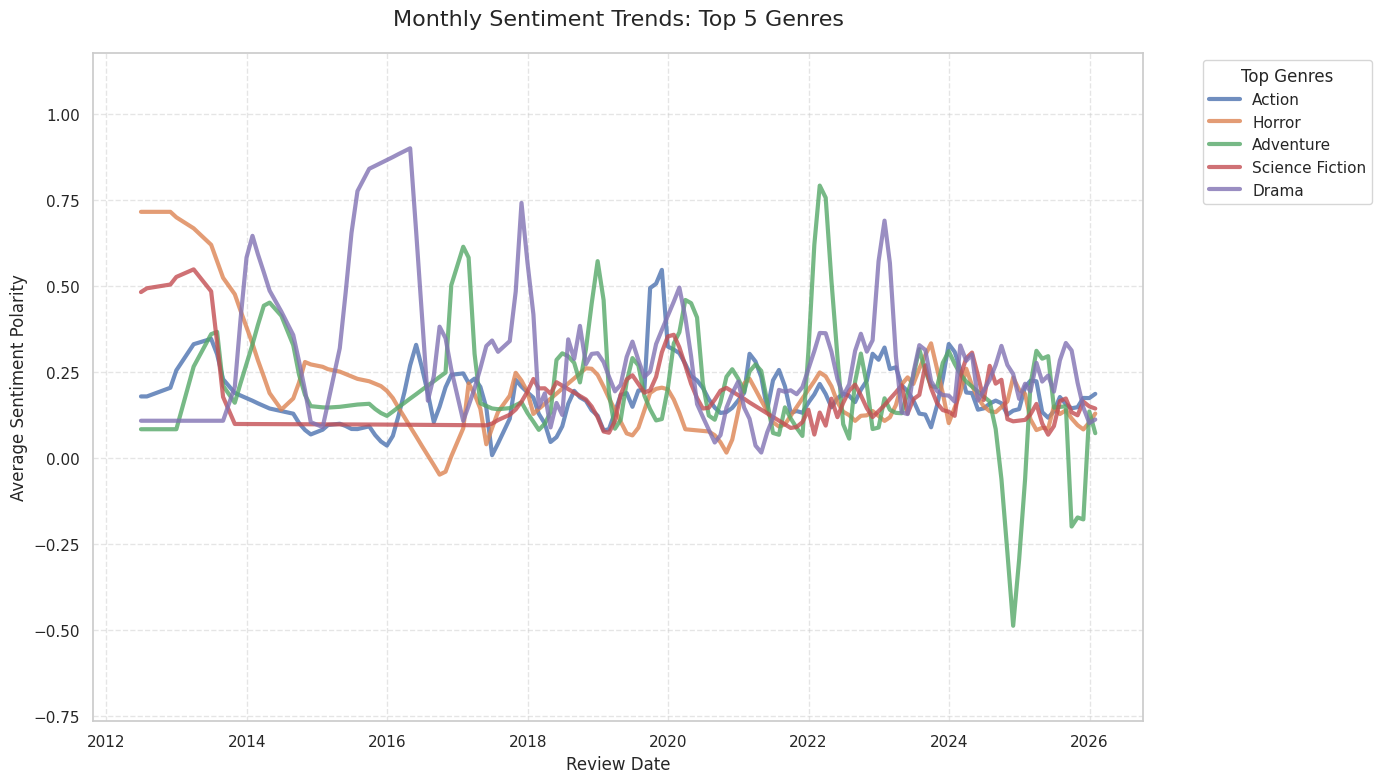

In [21]:
# Plotting the Trend
plt.figure(figsize=(14, 8))
for genre in filtered_trends.columns:
    plt.plot(filtered_trends.index, filtered_trends[genre],
             marker='', linewidth=3, label=genre, alpha=0.8)

plt.title('Monthly Sentiment Trends: Top 5 Genres', fontsize=16, pad=20)
plt.ylabel('Average Sentiment Polarity', fontsize=12)
plt.xlabel('Review Date', fontsize=12)
plt.margins(y=0.2)
plt.legend(title='Top Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

This line graph tracks the average monthly NLP sentiment polarity for the top five movie genres, offering a high-level view of how audience reception evolves over time.

**Key Insights**
* **Genre-Specific Volatility:** Reveals which genres maintain stable sentiment and which are prone to sharp "ups and downs" based on seasonal releases.

* **Performance Benchmarking:** Facilitates direct comparison between genres to see which categories consistently resonate most with audiences.

* **Event Correlation: Significant** peaks or dips often highlight the impact of specific blockbusters or "genre fatigue".

**How to Use This Information:**

* **Release Timing:** Helps studios identify optimal windows for releasing specific genres based on historical audience mood.

* **Market Sentiment Monitoring:** Acts as an early warning system for declining interest or shifts in narrative preferences within a category.

* **Content Strategy:** Informs creative decisions by identifying themes that drive sustained positive sentiment.

### **Summary**

This project successfully implemented an automated ETL pipeline to analyze movie sentiment from the TMDB API. It leveraged NLP techniques, including TextBlob for sentiment analysis, NLTK for POS filtering, and LDA for topic modeling. Key insights were derived from:

* **Sentiment Correlation**: Confirming alignment between NLP sentiment and numerical user ratings.
* **Genre Analysis**: Identifying sentiment distribution and trends across different movie genres.
* **Aspect-Based Sentiment**: Pinpointing specific aspects (e.g., 'acting' vs. 'plot') that drive audience opinion.
* **Topic Modeling**: Uncovering common themes and discussions within movie reviews.
* **Temporal Analysis**: Tracking how sentiment for top genres evolves over time.
* **WordClouds**: Visually summarizing dominant positive and negative descriptive terms, while noting the need for fine-tuning.

**Future Improvement Suggestions**

* **Advanced Model Integration:** Transitioning from rule-based tools like TextBlob to Transformer-based models (e.g., BERT or RoBERTa) to better capture sarcasm and complex context.

* **Expansion of Aspect Keywords:** Developing a more comprehensive dictionary for Aspect-Based Sentiment Analysis to include technical elements like cinematography, sound design, and pacing.

* **Enhanced Noise Filtering:** Implementing more sophisticated cleaning techniques, such as Lemmatization and an expanded custom stopword list, to further refine the WordCloud visualizations.

* **Correlation with Financial Data:** Integrating Box Office Revenue or Budget data to analyze the direct relationship between public sentiment and commercial success.

* **N-Gram Phrasal Analysis:** Moving beyond single-word analysis to Bigrams and Trigrams to capture more meaningful phrases in the review content.

Overall, this project provides a comprehensive framework for understanding and visualizing multi-dimensional movie sentiment, offering actionable insights for content strategy and market analysis.